In [1]:
%cd ../..

c:\Users\yanic\dev\ethz\cil\CIL2023


# Reconstruction
Reconstructs a mask from angle, width & distance data

#### Config

In [2]:
# folders should contain mean/ and std/ subfolders
angle_folder = "out/madw_angle/run_training"
dist_folder = "out/madw_dist/run_training"
width_folder = "out/madw_width/run_training"

#### This must be the same as in ADW-Transform-Individual!

In [ ]:
PADDING = 25
SMOOTH_ANGLE = 2.0 # None to disable
SMOOTH_WIDTH = 1.0 # None to disable
SMOOTH_MASK_ITERATIONS = 3

# the image size that the model will be working on (matters for distance prediction!)
TARGET_SIZE = (224,224) 
# leave at (400,400) if doing cropping
# use (224,224) if rescaling

NORM_ANGLE_MIN, NORM_ANGLE_DELTA = -3.15, 6.3
NORM_DISTANCE_MIN, NORM_DISTANCE_DELTA = 0, np.sqrt(2*(TARGET_SIZE[0] + 2*PADDING)**2) + 1
NORM_WIDTH_MIN, NORM_WIDTH_DELTA = 0, TARGET_SIZE[0] / 4 # this might cause some overflows if chosen too small

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
def nearest_neighbor_interpolation_2D(arr, target_size):
    current_size = arr.shape
    row_ratio, col_ratio = np.array(target_size)/np.array(current_size)

    row_idx = (np.ceil(range(1, 1 + int(current_size[0]*row_ratio))/row_ratio) - 1).astype(int)
    col_idx = (np.ceil(range(1, 1 + int(current_size[1]*col_ratio))/col_ratio) - 1).astype(int)

    return arr[:,row_idx][col_idx,:]

# Voting Phase

In this phase, the votes for all widths at each point in space are aggregated

In [6]:
def cart2pol(x, y, m_alpha):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    if m_alpha - phi > (2*np.pi + phi) - m_alpha:
        phi = 2*np.pi + phi
    return(rho, phi)

In [ ]:
res_total_weight_original = res_total_weight
res_width_mean_original = res_width_mean
res_width_std_original = res_width_std

In [93]:
original_size = 400

In [94]:
angle_mean = np.random.rand(original_size, original_size)
angle_std = np.random.rand(original_size, original_size)

dist_mean = np.random.rand(original_size, original_size)
dist_std = np.random.rand(original_size, original_size)

width_mean = np.random.rand(original_size, original_size)
width_std = np.random.rand(original_size, original_size)

In [283]:
mask,angle_mean,dist_mean,width_mean = np.load('../../data/training/transformed/mask_angle_distance_width/satimage_0.npy')
angle_std, dist_std, width_std = 0.1*np.ones((original_size,original_size)), 3.0 * np.ones((original_size,original_size)), 5.0 * np.ones((original_size,original_size))

In [284]:
# subsample
resize_factor = 0.25 # by how much will the image resolution be reduced
size = round(resize_factor * original_size)

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_std = np.ones((size,size))

angle_mean = nearest_neighbor_interpolation_2D(angle_mean, (size,size)) # invariant to scaling
angle_std = nearest_neighbor_interpolation_2D(angle_std, (size,size))
dist_mean = nearest_neighbor_interpolation_2D(dist_mean, (size,size)) * resize_factor # k * X ~ N(k * m, (k*s)^2)
dist_std = nearest_neighbor_interpolation_2D(dist_std, (size,size)) * resize_factor
width_mean = nearest_neighbor_interpolation_2D(width_mean, (size,size)) # keep original scale
width_std = nearest_neighbor_interpolation_2D(width_std, (size,size))

In [297]:
indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

indices_2d = np.stack([indices_ext, indices_ext.T], axis=-1)
angles = np.arctan2(indices_2d[:,:,0], indices_2d[:,:,1])

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_var = np.ones((size,size))

joint_norm_std = 1 / (2 * np.pi * angle_std * dist_std)
for y in tqdm(range(size)):
    for x in range(size):
        local_angle_mean = angle_mean[y,x]
        local_angle_std = angle_std[y,x]
        local_dist_mean = dist_mean[y,x]
        local_dist_std = dist_std[y,x]
        local_width_mean = width_mean[y,x]
        local_width_var = width_std[y,x] * width_std[y,x]
        
        local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
        local_angles = angles[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
        closest_local_angles = local_angles + 2*np.pi*(local_angle_mean > np.pi + local_angles) 

        prop_that_road = joint_norm_std[y,x] * np.exp(-0.5 * (((closest_local_angles - local_angle_mean) / local_angle_std)**2 + ((local_dists - local_dist_mean) / local_dist_std)**2))

        res_total_weight += prop_that_road
        res_width_mean += prop_that_road * local_width_mean
        res_width_var += prop_that_road * (local_width_var + local_width_mean**2)
res_width_mean /= res_total_weight
res_width_var /= res_total_weight
res_width_var -= res_width_mean**2
res_width_std = np.sqrt(res_width_var)

# TODO: upsample using linear interpolation
vote_width_mean = res_width_mean
vote_width_std = res_width_std

vote_width_mean[res_total_weight < 5.0] = 0
vote_width_std[res_total_weight < 5.0] = 1.0
# vote_width_mean = nearest_neighbor_interpolation_2D(res_width_mean / resize_factor, (original_size,original_size))
# vote_width_std = nearest_neighbor_interpolation_2D(res_width_std / resize_factor, (original_size,original_size))

100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


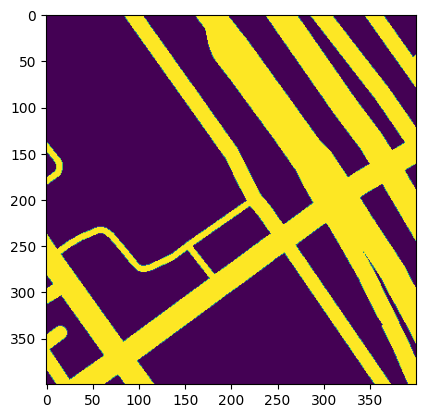

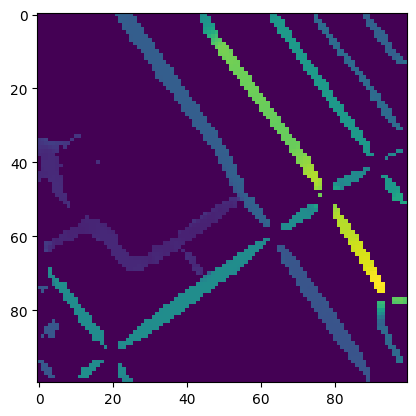

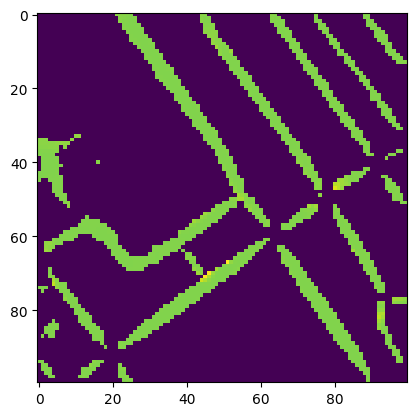

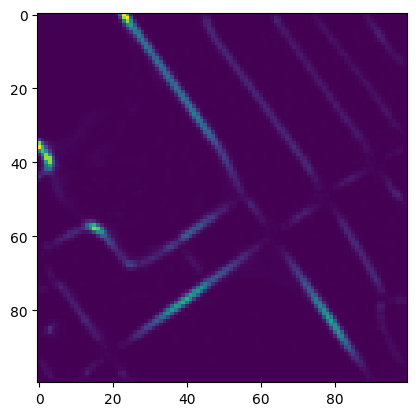

In [298]:
plt.imshow(mask)
plt.show()
plt.imshow(res_width_mean)
plt.show()
plt.imshow(res_width_std)
plt.show()
plt.imshow(res_total_weight)
plt.show()

# Final Mask From Votes

In [299]:
size = size

# since we don't upscale
vote_width_mean *= resize_factor
vote_width_std *= resize_factor 

In [300]:
indices_ext = np.array([range(-size+1, size)]).T @ np.ones((1,2*size-1))
dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

res_mask = np.zeros((size,size))

inv_with_std_times_sqrt2 = 1.0 / (vote_width_std * np.sqrt(2))
for y in tqdm(range(size)):
    for x in range(size):
        if vote_width_mean[y,x] < 0.1: 
            continue
        
        norm = stats.norm(vote_width_mean[y,x], vote_width_std[y,x])
        local_dists = dists[size-1-y:size-1-y+size,size-1-x:size-1-x+size]
        
        prop_that_road = 1.0 - norm.cdf(local_dists)
        #prop_that_road = 1.0 - (1 + erf((local_dists - vote_width_mean[y,x]) * inv_with_std_times_sqrt2)) * 0.5

        res_mask = np.maximum(res_mask, prop_that_road)
        #res_mask += prop_that_road

100%|██████████| 100/100 [00:01<00:00, 57.67it/s]


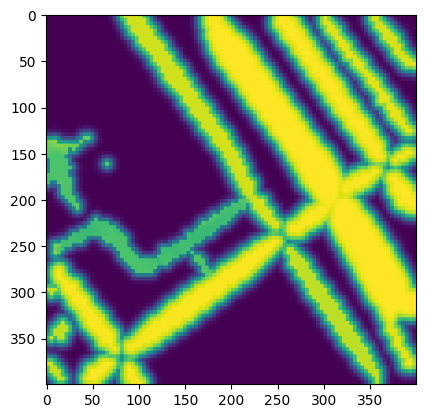

In [302]:
#res_mask[res_mask < 0.25] = 0
plt.imshow(nearest_neighbor_interpolation_2D(res_mask, (original_size,original_size)))


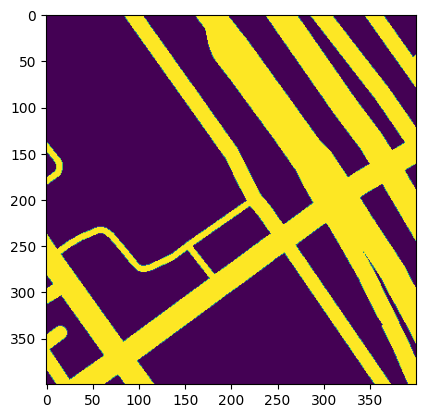

In [275]:
plt.imshow(mask)

(array([ 17.,   2.,  14.,  28.,  38.,  62.,  58.,  57.,  56., 692.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

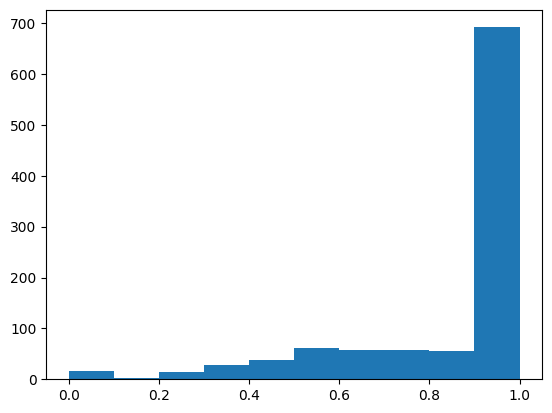

In [214]:
plt.hist(res_mask.flatten())

In [11]:
import torch

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

angle_mean = torch.rand((224, 224)).to(device)
angle_std = torch.rand((224, 224)).to(device)

dist_mean = torch.rand((224, 224)).to(device)
dist_std = torch.rand((224, 224)).to(device)

width_mean = torch.rand((224, 224)).to(device)
width_std = torch.rand((224, 224)).to(device)

res_total_weight = torch.zeros((224,224)).to(device)
res_width_mean = torch.zeros((224,224)).to(device)
res_width_std = torch.ones((224,224)).to(device)

sqrt2pi = np.sqrt(2*np.pi)

indices_ext = np.array([range(-223, 224)]).T @ np.ones((1,223+224))
dists = np.sqrt(np.sum(np.stack([indices_ext**2, indices_ext.T**2], axis=-1), axis=-1))

indices_2d = np.stack([indices_ext, indices_ext.T], axis=-1)
angles = np.arctan2(indices_2d[:,:,0], indices_2d[:,:,1])

dists = torch.Tensor(dists).to(device)
angles = torch.Tensor(angles).to(device)

joint_mean = (dist_std * angle_mean + angle_std * dist_mean) / (dist_std + angle_std)
joint_std = 1.0 / (1.0 / dist_std + 1.0 / angle_std)

prop_that_road = np.zeros((224,224,224,224))
for y in tqdm(range(224)):
    for x in range(224):
        local_dists = dists[223-y:223-y+224,223-x:223-x+224]
        local_angles = angles[223-y:223-y+224,223-x:223-x+224]
        closest_local_angles = local_angles + 2*np.pi*(local_angle > np.pi + local_angles) 

        prop_that_road[y,x,:,:] = joint_mean[y,x] + joint_std[y,x] * np.exp(-(local_dists * closest_local_angles)**2 * 0.5) / sqrt2pi

res_total_weight = torch.sum(prop_that_road, dim=(0,1))
res_width_mean += torch.sum(prop_that_road * width_mean.unsqueeze(0).unsqueeze(1), dim=(0,1))
res_width_std += torch.sum(prop_that_road * width_std.unsqueeze(0).unsqueeze(1), dim=(0,1))

# Original Implementations

In [ ]:
# Correct original implementation
size = 32
angle_mean = np.random.rand(size, size)
angle_std = np.random.rand(size, size)

dist_mean = np.random.rand(size, size)
dist_std = np.random.rand(size, size)

width_mean = np.random.rand(size, size)
width_std = np.random.rand(size, size)

res_total_weight = np.zeros((size,size))
res_width_mean = np.zeros((size,size))
res_width_std = np.ones((size,size))
for y in tqdm(range(size)):
    for x in range(size):
        prop_that_road = np.zeros((size,size))
        local_angle = angle_mean[y,x]
        norm_angle = stats.norm(local_angle, angle_std[y,x])
        norm_dist = stats.norm(dist_mean[y,x], dist_std[y,x])
        
        for ty in range(size):
            for tx in range(size):
                dist,angle = cart2pol(tx - x, ty - y, local_angle)
                prop_that_road = norm_angle.pdf(angle) * norm_dist.pdf(dist)
    
                res_total_weight[ty,tx] += prop_that_road
                res_width_mean[ty,tx] += prop_that_road * width_mean[y,x]
                res_width_std[ty,tx] += prop_that_road * width_std[y,x] # TODO: use correct formula!

vote_width_mean = (res_width_mean / res_total_weight)
vote_width_std = (res_width_std / res_total_weight)